In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, Reshape, MaxPool2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
print(tf.__version__)

2.4.1


In [2]:
BATCH_SIZE = 64
NUM_EPOCHS = 10
IM_SIZE = 28
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
def load_data():
  (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0
  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)
  return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_data()
mean_train = np.mean(train_images)
std_train = np.std(train_images)

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
def define_teacher_model_conv():
  inp = Input(shape=(IM_SIZE, IM_SIZE, 1), name="input")
  conv1 = Conv2D(32, 5, activation="tanh", name="conv1")(inp)
  pool1 = MaxPool2D(name="pool1")(conv1)
  conv2 = Conv2D(16, 3, activation="tanh", name="conv2")(pool1)
  pool2 = MaxPool2D(name="pool2")(conv2)
  flattened = Flatten(name="flatten")(pool2)
  out = Dense(10, activation='softmax', name="dense2")(flattened)
  model = Model(inputs=inp, outputs=out)
  model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])
  
  intermediate_model = Model(inputs=inp, outputs=[conv2, out])
  intermediate_model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])
  return model, intermediate_model

In [5]:
def define_student_model_conv():
  inp = Input(shape=(IM_SIZE, IM_SIZE, 1), name="input_student")
  conv1 = Conv2D(32, 5, activation="tanh", name="conv1_student")(inp)
  pool1 = MaxPool2D(name="pool1_student")(conv1)
  conv2 = Conv2D(16, 3, activation="tanh", name="conv2_student")(pool1)
  pool2 = MaxPool2D(name="pool2_student")(conv2)
  flattened = Flatten(name="flatten_student")(pool2)
  out = Dense(10, activation='softmax', name="dense2_student")(flattened)
  student_model = Model(inputs=inp, outputs=[conv2, out])
  student_model.compile(loss=["mean_absolute_error", "categorical_crossentropy"],
              optimizer="adam",
              metrics=[None, 'accuracy'])
  
  validation_model = Model(inputs=inp, outputs=out)
  validation_model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])
  return student_model, validation_model

In [6]:
def train_teacher(model, train_images, train_labels, test_images, test_labels):
  model.fit(train_images, train_labels,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          verbose=1,
          validation_data=(test_images, test_labels))
  return model


In [7]:
def generate_noise(shape):
  while True:
    random_batch = np.random.normal(loc=mean_train, scale=std_train, size=shape)
    random_batch = np.clip(random_batch, 0, 1)
    yield random_batch

def generate_samples(shape, teacher_model):
  while True:
    inp = next(generate_noise(shape))
    labels = teacher_model.predict(inp)
    yield (inp, labels)


def train_student(student_model, validation_model, teacher_model, test_images, test_labels):
  gen = generate_samples((BATCH_SIZE, IM_SIZE, IM_SIZE), teacher_model)
  next(gen)
  for i in range(NUM_EPOCHS):
    student_model.fit_generator(gen, steps_per_epoch=10000, epochs=1, verbose=1)
    validation_model.evaluate(test_images, test_labels)
  return student_model

In [8]:
teacher_model, intermediate_teacher_model = define_teacher_model_conv()
teacher_model = train_teacher(teacher_model, train_images, train_labels, test_images, test_labels)

Epoch 1/10
938/938 [==============================] - 36s 38ms/step - loss: 0.6261 - accuracy: 0.8225 - val_loss: 0.1055 - val_accuracy: 0.9686
Epoch 2/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0999 - accuracy: 0.9717 - val_loss: 0.0616 - val_accuracy: 0.9812
Epoch 3/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0670 - accuracy: 0.9808 - val_loss: 0.0491 - val_accuracy: 0.9855
Epoch 4/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0543 - accuracy: 0.9848 - val_loss: 0.0425 - val_accuracy: 0.9862
Epoch 5/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0440 - accuracy: 0.9874 - val_loss: 0.0399 - val_accuracy: 0.9872
Epoch 6/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0400 - accuracy: 0.9883 - val_loss: 0.0381 - val_accuracy: 0.9878
Epoch 7/10
938/938 [==============================] - 35s 37ms/step - loss: 0.0331 - accuracy: 0.9900 - val_loss: 0.0364 - val_accuracy:

In [ ]:
student_model, validation_model = define_student_model_conv()
student_model.summary()
student_model = train_student(student_model, validation_model, intermediate_teacher_model, test_images, test_labels)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_student (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1_student (Conv2D)       (None, 24, 24, 32)        832       
_________________________________________________________________
pool1_student (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2_student (Conv2D)       (None, 10, 10, 16)        4624      
_________________________________________________________________
pool2_student (MaxPooling2D) (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_student (Flatten)    (None, 400)               0         
_________________________________________________________________
dense2_student (Dense)       (None, 10)                4010

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


 6899/10000 [===================>..........] - ETA: 4:37 - loss: 0.0770 - conv2_student_loss: 0.0737 - dense2_student_loss: 0.0032 - conv2_student_accuracy: 0.8471 - dense2_student_accuracy: 0.9887

In [ ]:
print(np.argmax(validation_model.predict(test_images[:15]), axis=1))
print(np.argmax(test_labels[:15], axis=1))

validation_model.evaluate(test_images, test_labels)

[9 2 1 0 4 1 4 9 5 9 0 6 9 0 1]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1]
313/313 [==============================] - 2s 6ms/step - loss: 0.8984 - accuracy: 0.8514


[0.8983574509620667, 0.8514000177383423]

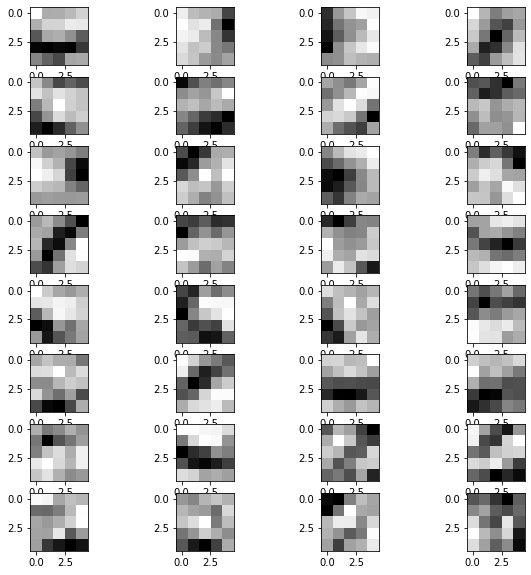

In [ ]:
for i in range(32):
  plt.subplot(8, 4, i+1)
  plt.imshow(intermediate_teacher_model.layers[1].get_weights()[0][:,:,0,i], cmap="gray")


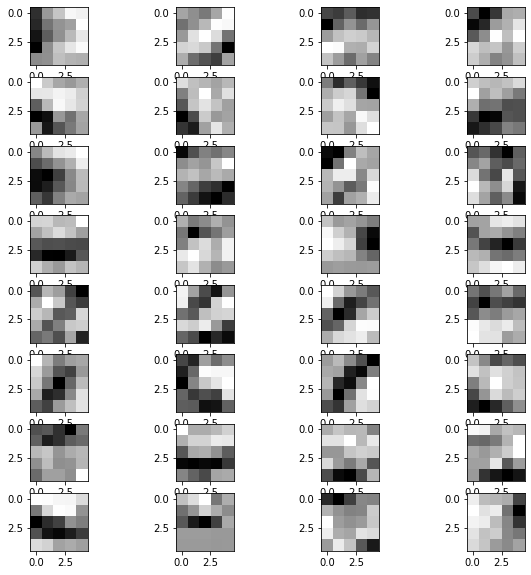

In [ ]:
for i in range(32):
  plt.subplot(8, 4, i+1)
  plt.imshow(student_model.layers[1].get_weights()[0][:,:,0,i], cmap="gray")



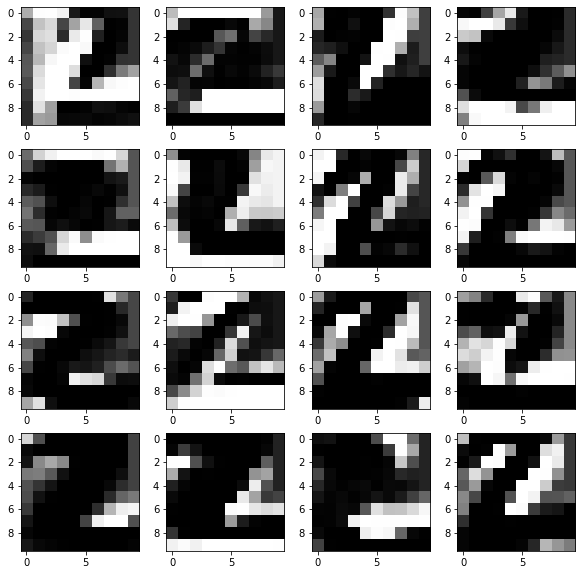

In [ ]:
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(intermediate_teacher_model.predict(test_images[1:2])[0][0,:,:, i], cmap="gray")

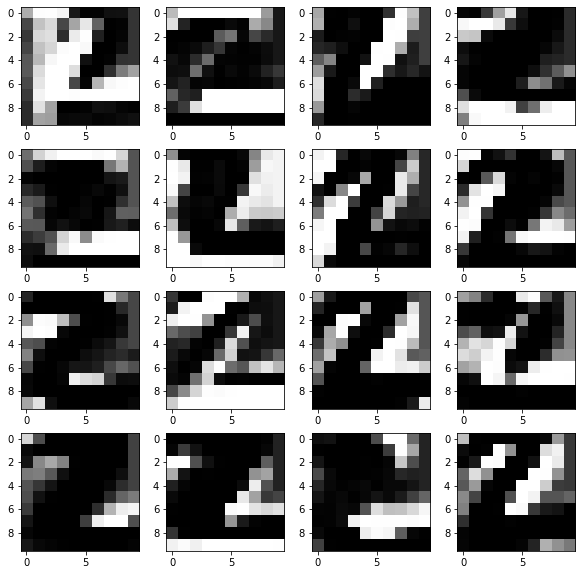

In [ ]:
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(student_model.predict(test_images[1:2])[0][0,:,:, i], cmap="gray")

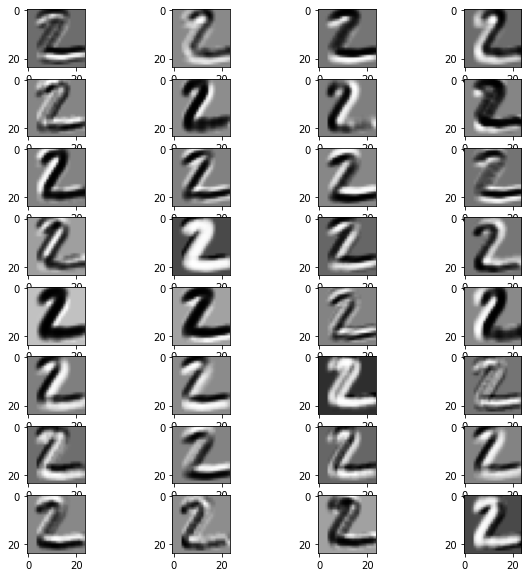

In [ ]:
for i in range(32):
  plt.subplot(8, 4, i+1)
  plt.imshow(intermediate_teacher_model.predict(test_images[1:2])[0][0,:,:,i], cmap="gray")

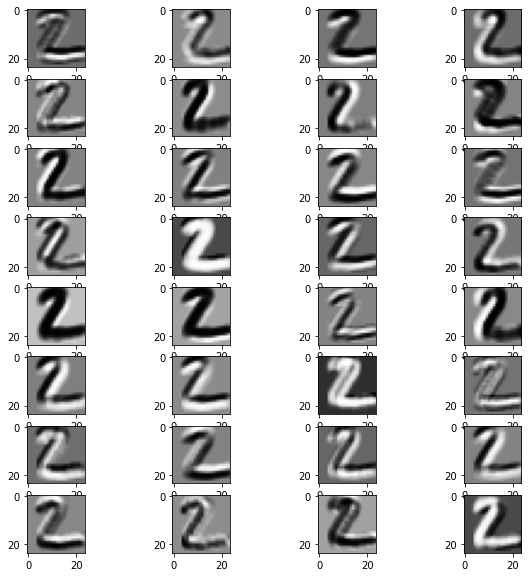

In [ ]:
for i in range(32):
  plt.subplot(8, 4, i+1)
  plt.imshow(student_model.predict(test_images[1:2])[0][0,:,:,i], cmap="gray")

In [ ]:
np.sum(np.abs(intermediate_teacher_model.layers[1].get_weights()[1] - student_model.layers[1].get_weights()[1]))


0.004006818